# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook. 

Also don't forget to **enable GPU** before your training.


In [1]:
#
# Add your code here
#
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

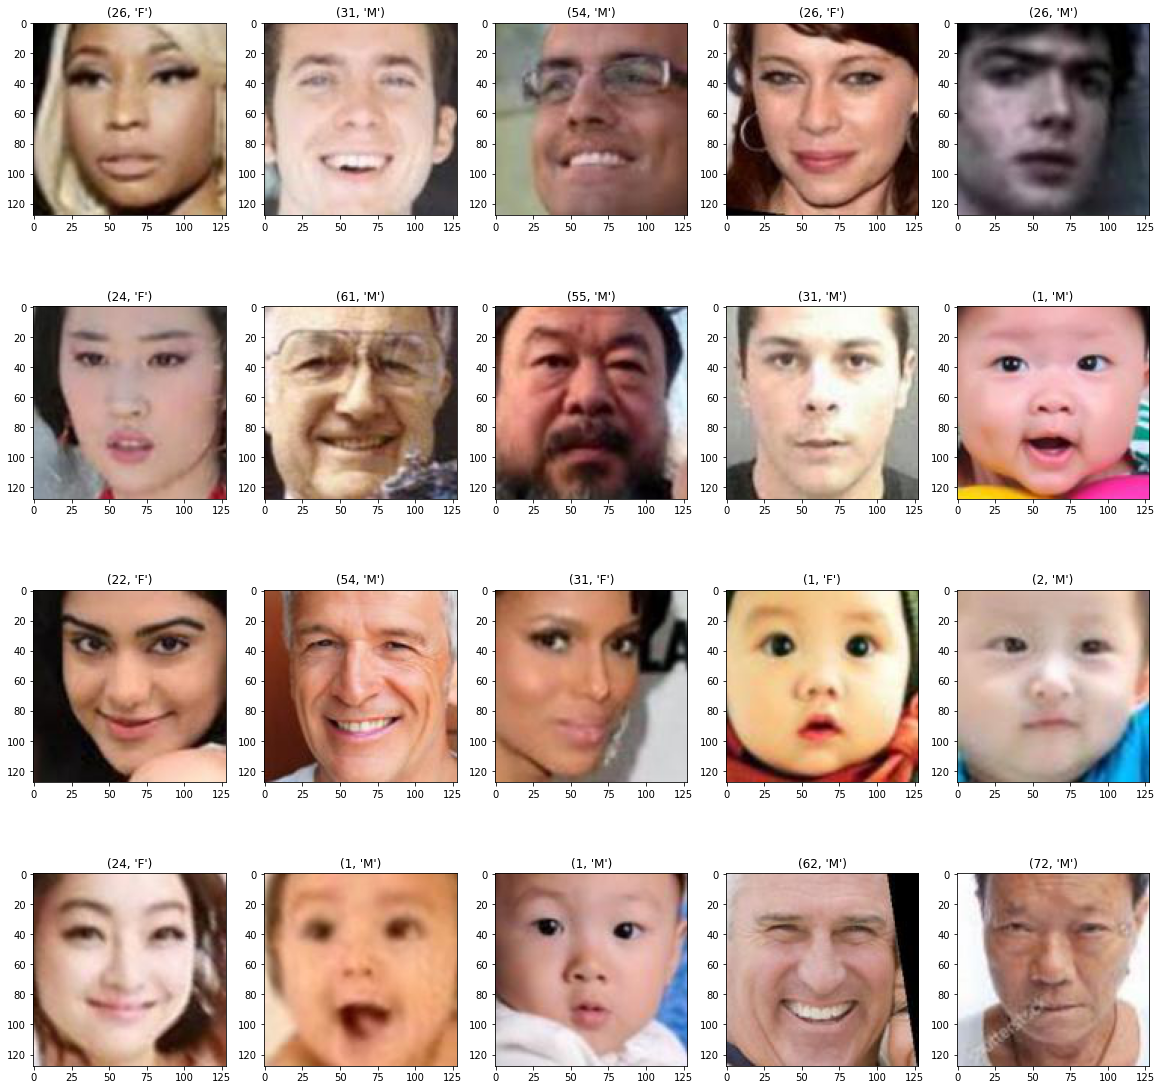

In [2]:
import os
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import numpy as np

folder = '/content/drive/MyDrive/CW1/train_val'
## Print out 20 images
plt.figure(figsize=(20,20))
def load_images_from_folder(folder, no_of_image):
  for i in range(no_of_image):
    file = np.random.choice(os.listdir(folder))
    file_split = file.split('_')
    age = file_split[0]
    gender = "M" if file_split[1] == "0" else "F"
    head = (int(age), gender)
    image_path= os.path.join(folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(4,5,i+1)
    ax.title.set_text(head)
    plt.imshow(img)

load_images_from_folder(folder, 20)




## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [4]:
from sklearn.model_selection import train_test_split
from  matplotlib import pyplot as plt
# import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import cv2

gdrive_dir = '/content/drive/MyDrive/CW1'
original_dataset_dir = gdrive_dir+'/train_val'

ages=[]
genders=[]
images=[]
labels=[]

## Split the data into image(pixels), age, gender and label(age + gender)
for i in os.listdir(original_dataset_dir):
  age = int(i.split('_')[0])
  gender = int(i.split('_')[1])
  path = os.path.join(original_dataset_dir, i)
  image = cv2.imread(path)
  images.append(image)
  labels.append([[age], [gender]])

image_array = np.array(images)
label_array = np.array(labels)
x_train, x_val, y_train, y_val = train_test_split(image_array, label_array, test_size=0.2)
y_train = [y_train[:,1], y_train[:,0]]
y_val = [y_val[:,1], y_val[:,0]]
y_train_gender = y_train[0]
y_val_gender = y_val[0]
y_train_age = y_train[1]
y_val_age = y_val[1]

list_of_tuples = list(zip(image_array, label_array))
df = pd.DataFrame(list_of_tuples, columns = ['image', 'label'])
df = df.dropna()

In [5]:
df.head()

,image,label
0,"[[[243, 248, 247], [242, 247, 246], [241, 243,...","[[40], [0]]"
1,"[[[117, 121, 139], [123, 127, 145], [132, 137,...","[[75], [0]]"
2,"[[[42, 65, 97], [41, 64, 96], [43, 66, 98], [4...","[[18], [1]]"
3,"[[[15, 21, 28], [10, 18, 25], [10, 18, 25], [1...","[[70], [1]]"
4,"[[[121, 128, 125], [115, 122, 119], [107, 113,...","[[26], [1]]"


In [6]:
print("Data training: " + str(len(x_train)))
print("Data validation: " + str(len(x_val)))

Data training: 4000
Data validation: 1000


## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way. 
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage. 

In [7]:
from keras.models import Sequential

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from PIL import Image
from keras.models import Sequential
from keras import layers
from keras.preprocessing.image import ImageDataGenerator

## Data Augmentation + rescaling for training set
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip=True,
    validation_split=0.2)

## Rescaling for validation set 
val_datagen = ImageDataGenerator(rescale=1./255)

train_datagen.fit(x_train)

val_datagen.fit(x_val)



## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting. 
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting. 

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 124, 124, 64  18496       ['conv2d[0][0]']                 
                                )                                                             

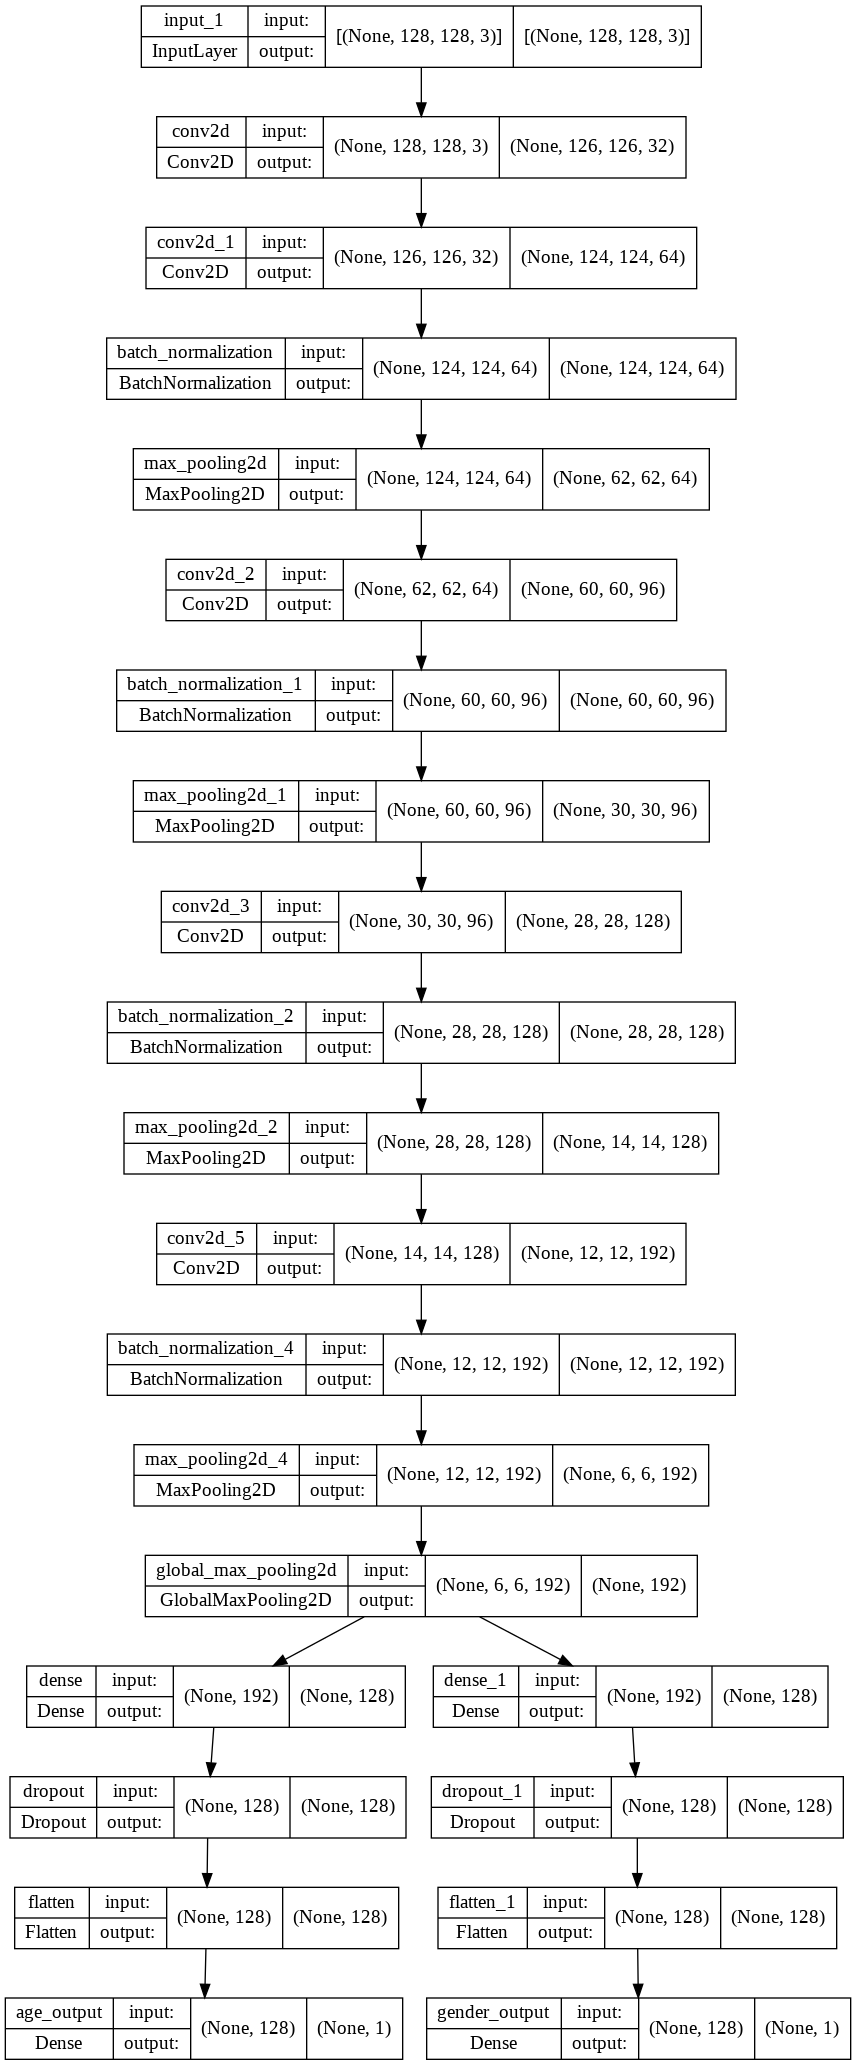

In [8]:

from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout, Flatten

def conv_block(inp, filters=32, bn=True, pool=True):
    _ = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)
    if bn:
        _ = BatchNormalization()(_)
    if pool:
        _ = MaxPool2D()(_)
    return _

input_layer = Input(shape=(128, 128, 3))
x = conv_block(input_layer, filters=32, bn=False, pool=False)
x = conv_block(x, filters=32*2)
x = conv_block(x, filters=32*3)
x = conv_block(x, filters=32*4)
x_ = conv_block(x, filters=32*5)
x = conv_block(x, filters=32*6)
a = GlobalMaxPool2D()(x)



x = Dense(units=128, activation='relu')(a)
x = Dropout(0.4)(x)
x = Flatten()(x)
# x = Dense(units=1, activation='sigmoid', name='gender_output')(x)
age_output = Dense(units=1, activation='linear', name='age_output')(x)

x = Dense(units=128, activation='relu')(a)
x = Dropout(0.4)(x)
x = Flatten()(x)
# x = Dense(units=1, activation='linear', name='age_output')(x)
gender_output = Dense(units=1, activation='sigmoid', name='gender_output')(x)

input_shape = (128, 128, 3)
inputs = Input(shape=input_shape)
# age_output = age_A(inputs)
# gender_output = gender_A(inputs)

modelA = Model(inputs=input_layer, outputs=[age_output, gender_output])

modelA.summary()
from keras.utils.vis_utils import plot_model
plot_model(modelA, show_shapes=True)

## STEP3A: Compile and train your model
Compile and train your model here. 
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by 

`modelA = load_model(model_folder+"age_gender_A.h5")`. 


In [9]:
#
# Add your code here
#
!mkdir -p saved_modelA
import tensorflow as tf

from keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

model_save = '/content/drive/MyDrive/model_save'
if not os.path.exists(model_save):
  os.mkdir(model_save)

def scheduler (epoch, lr):
  if epoch < 25:
    return lr
  else:
    return lr * np.exp(-0.1*(epoch-25))

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='saved_modelA/',
    save_weights_only=True,
    monitor='val_gender_output_accuracy',
    mode='max',
    save_best_only=True)

#earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
callback = LearningRateScheduler(scheduler)

modelA.compile(optimizer='adam',
              loss={'age_output': 'mae', 'gender_output': 'binary_crossentropy'},
              metrics={'age_output': 'mae', 'gender_output': 'accuracy'})

history = modelA.fit(x_train, [y_train_age, y_train_gender],
                    epochs=30,
                    validation_data=(x_val, [y_val_age, y_val_gender]),
                    callbacks=[model_checkpoint_callback, callback])


modelA.save(model_save+'/'+"age_gender_A.h5")

Epoch 1/30
125/125 [==============================] - 20s 133ms/step - loss: 16.4123 - age_output_loss: 15.6134 - gender_output_loss: 0.7989 - age_output_mae: 15.6134 - gender_output_accuracy: 0.6133 - val_loss: 27.2360 - val_age_output_loss: 25.2926 - val_gender_output_loss: 1.9433 - val_age_output_mae: 25.2926 - val_gender_output_accuracy: 0.4970 - lr: 0.0010
Epoch 2/30
125/125 [==============================] - 15s 121ms/step - loss: 14.1373 - age_output_loss: 13.5001 - gender_output_loss: 0.6372 - age_output_mae: 13.5001 - gender_output_accuracy: 0.6440 - val_loss: 14.6573 - val_age_output_loss: 13.8088 - val_gender_output_loss: 0.8485 - val_age_output_mae: 13.8088 - val_gender_output_accuracy: 0.4960 - lr: 0.0010
Epoch 3/30
125/125 [==============================] - 15s 121ms/step - loss: 13.1746 - age_output_loss: 12.5667 - gender_output_loss: 0.6078 - age_output_mae: 12.5667 - gender_output_accuracy: 0.6670 - val_loss: 12.7057 - val_age_output_loss: 12.0701 - val_gender_output_l

## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


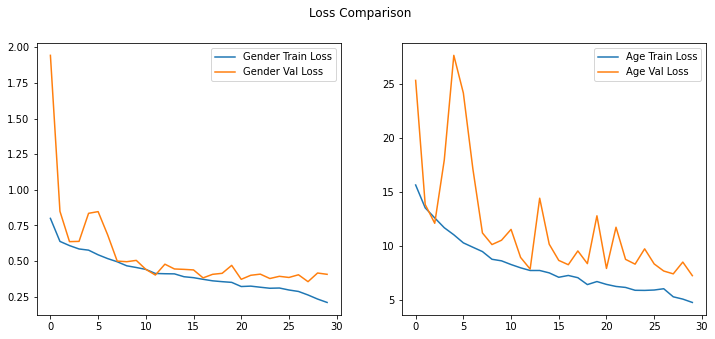

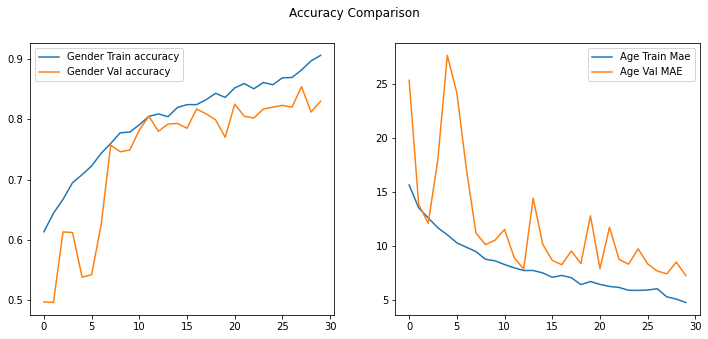

In [10]:
#
# Add your code here
#
def  plot_train_history(history):

    fig = plt.figure(figsize = (12, 5))
    fig.suptitle("Loss Comparison")
    plt.subplot(1, 2, 1)
    plt.plot(history.history['gender_output_loss'], label='Gender Train Loss')
    plt.plot(history.history['val_gender_output_loss'], label='Gender Val Loss')
    
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['age_output_loss'], label='Age Train Loss')
    plt.plot(history.history['val_age_output_loss'], label='Age Val Loss')
    
    plt.legend()  

    fig = plt.figure(figsize = (12, 5))
    fig.suptitle("Accuracy Comparison")

    plt.subplot(1, 2, 1)
    plt.plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    plt.plot(history.history['val_gender_output_accuracy'], label='Gender Val accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['age_output_mae'], label='Age Train Mae')
    plt.plot(history.history['val_age_output_mae'], label='Age Val MAE')
    plt.legend()  

plot_train_history(history)

## STEP2B: Build a CNN network based on a pre-trained model 
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**. 

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

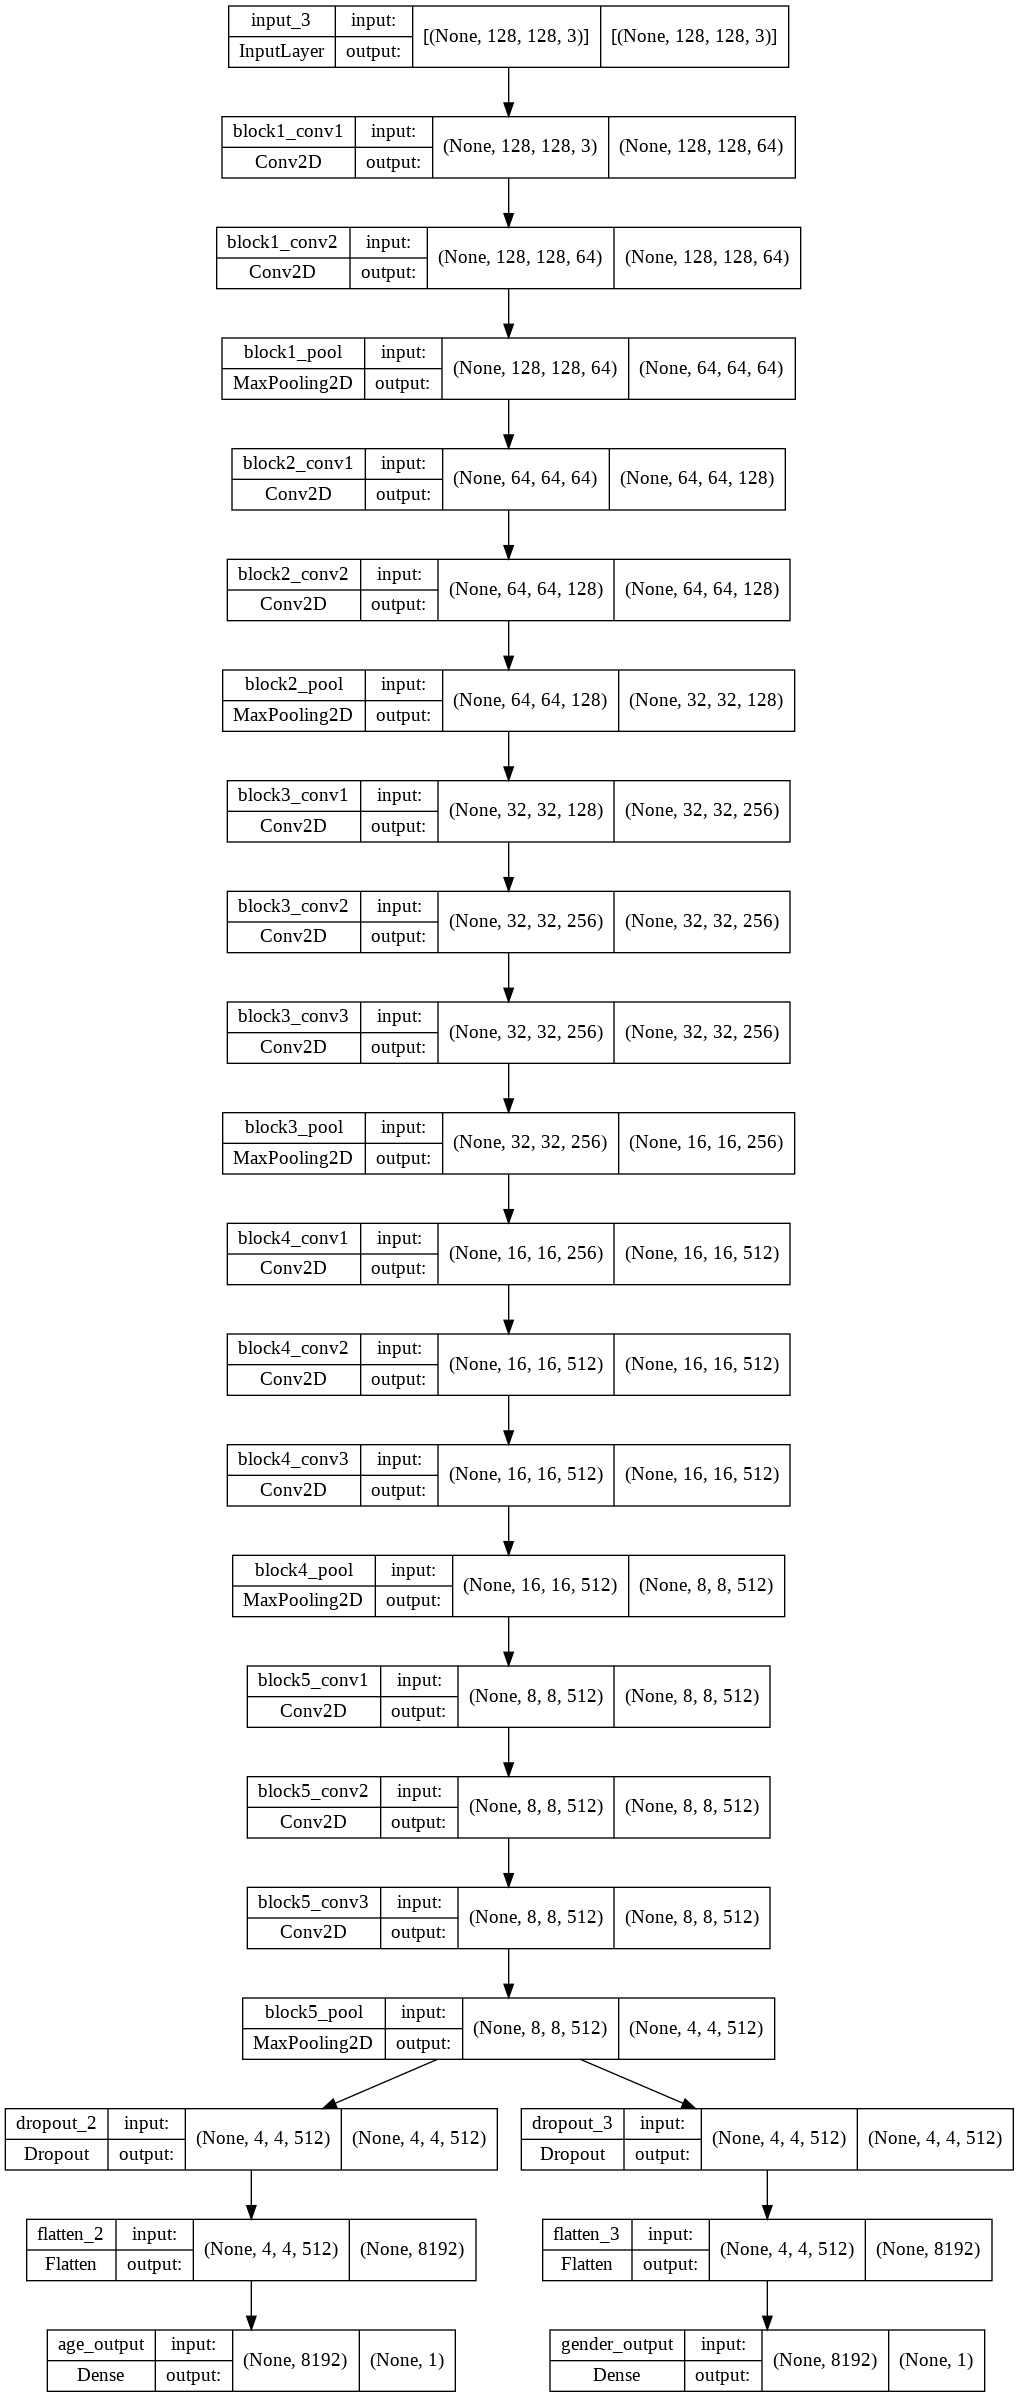

In [11]:
#
# Add your code here
#
from keras.applications import vgg16
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

conv_base = vgg16.VGG16(include_top = False, weights = 'imagenet', input_shape = (128, 128, 3))
# Freeze four convolution blocks
for layer in conv_base.layers[:15]:
    layer.trainable = False

def gender_B():
  x = conv_base.output
  x = Dropout(0.4)(x)
  x = Flatten()(x)
  x = Dense(1, activation='sigmoid',  name="gender_output")(x)
  return x

def age_B():
  x = conv_base.output
  x = Dropout(0.4)(x)
  x = Flatten()(x)
  x = Dense(1, activation='linear',  name="age_output")(x)
  return x

input_shape = (128, 128, 3)
inputs = Input(shape=input_shape)
age_B = age_B()
gender_B = gender_B()

modelB = Model(inputs=conv_base.input,  outputs = [age_B, gender_B])

modelB.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True)

## STEP3B: Compile and train your model
Compile and train your model here. 
Save your model to `age_gender_B.h5` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.** 


In [12]:
#
# Add your code here
#
!mkdir -p saved_modelB
import tensorflow as tf

from keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

def scheduler (epoch, lr):
  if epoch < 25:
    return lr
  else:
    return lr * np.exp(-0.1*(epoch-25))

model_save = '/content/drive/MyDrive/model_save'
if not os.path.exists(model_save):
  os.mkdir(model_save)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='saved_modelB/',
    save_weights_only=True,
    monitor='val_gender_output_accuracy',
    mode='max',
    save_best_only=True)

callback = LearningRateScheduler(scheduler)

modelB.compile(optimizer='adam',
              loss={'age_output': 'mae', 'gender_output': 'binary_crossentropy'},
              metrics={'age_output': 'mae', 'gender_output': 'accuracy'})



history = modelB.fit(x_train, [y_train_age, y_train_gender],
                    epochs=30,
                    validation_data=(x_val, [y_val_age, y_val_gender]),
                    callbacks=[model_checkpoint_callback, callback])

modelB.save(model_save+'/'+"age_gender_B.h5")

Epoch 1/30
125/125 [==============================] - 22s 154ms/step - loss: 26.3685 - age_output_loss: 24.1872 - gender_output_loss: 2.1812 - age_output_mae: 24.1872 - gender_output_accuracy: 0.5067 - val_loss: 25.7557 - val_age_output_loss: 25.0606 - val_gender_output_loss: 0.6952 - val_age_output_mae: 25.0606 - val_gender_output_accuracy: 0.4960 - lr: 0.0010
Epoch 2/30
125/125 [==============================] - 20s 161ms/step - loss: 16.1328 - age_output_loss: 15.1933 - gender_output_loss: 0.9395 - age_output_mae: 15.1933 - gender_output_accuracy: 0.5157 - val_loss: 12.5600 - val_age_output_loss: 11.8968 - val_gender_output_loss: 0.6632 - val_age_output_mae: 11.8968 - val_gender_output_accuracy: 0.6080 - lr: 0.0010
Epoch 3/30
125/125 [==============================] - 18s 144ms/step - loss: 13.7212 - age_output_loss: 12.8252 - gender_output_loss: 0.8960 - age_output_mae: 12.8252 - gender_output_accuracy: 0.5592 - val_loss: 8.9832 - val_age_output_loss: 8.3319 - val_gender_output_los

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

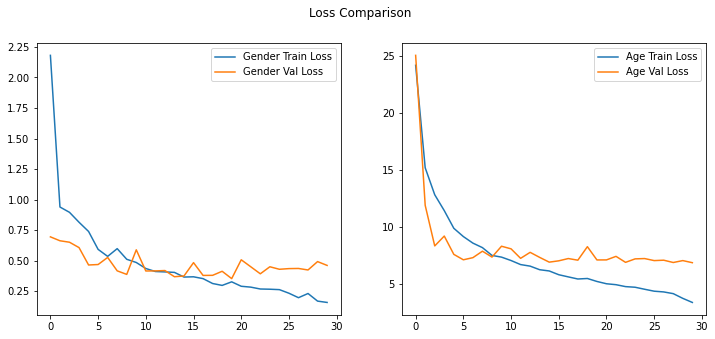

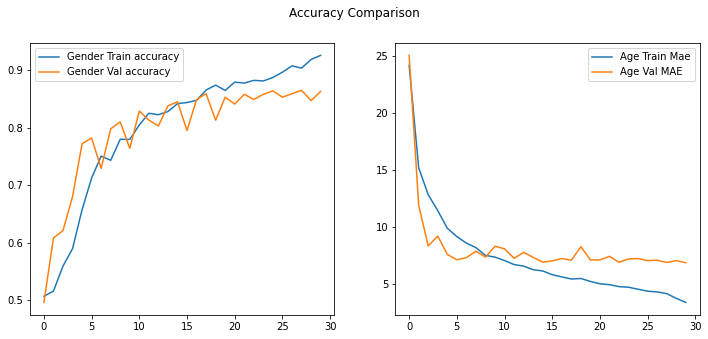

In [13]:
#
# Add your code here
#
def  plot_train_history(history):

    fig = plt.figure(figsize = (12, 5))
    fig.suptitle("Loss Comparison")
    plt.subplot(1, 2, 1)
    plt.plot(history.history['gender_output_loss'], label='Gender Train Loss')
    plt.plot(history.history['val_gender_output_loss'], label='Gender Val Loss')
    # plt.ylim([0,15])
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['age_output_loss'], label='Age Train Loss')
    plt.plot(history.history['val_age_output_loss'], label='Age Val Loss')
    # plt.ylim([0,15])
    
    plt.legend()  

    fig = plt.figure(figsize = (12, 5))
    fig.suptitle("Accuracy Comparison")

    plt.subplot(1, 2, 1)
    plt.plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    plt.plot(history.history['val_gender_output_accuracy'], label='Gender Val accuracy')
    # plt.ylim([0,1.0])
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['age_output_mae'], label='Age Train Mae')
    plt.plot(history.history['val_age_output_mae'], label='Age Val MAE')
    # plt.ylim([0,15])
    
    plt.legend()  

plot_train_history(history)

## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission. 

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [14]:
#
# Don't add code in this cell when submitting this file
#